# Forex prediction with ARIMA

## Importing basic libraries

In [128]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


from pmdarima import auto_arima

## Loading data

In [129]:
df = pd.read_csv('data.csv')
df.datetime = pd.to_datetime(df.datetime)
df.set_index('datetime', inplace=True)

df_column_names = df.columns
df_lowercase_column_names = []

for name in df_column_names:
    lowercase_name = name.lower()
    df_lowercase_column_names.append(lowercase_name)   
    
df.columns = df_lowercase_column_names

df.day_of_week = df.day_of_week - np.min(df.day_of_week) + 1

In [130]:
df.head()

,close,high,low,open,volume,price_change,price_change_abs,high_low_ratio,close_open_ratio,hour,...,reddit_title_sentiment_mean,reddit_title_sentiment_std,reddit_title_sentiment_count,reddit_score_mean,reddit_score_sum,reddit_score_max,reddit_num_comments_mean,reddit_num_comments_sum,reddit_upvote_ratio_mean,fear_greed
datetime,,,,,,,,,,,,,,,,,,,,,
2025-04-23 03:00:00,4.28371,4.28800,4.28271,4.28317,0,-0.000005,0.000005,1.001235,1.000126,3,...,0.070833,0.094648,4,129.750000,519,451,21.000000,84,0.782500,28.428571
2025-04-23 04:00:00,4.28466,4.28730,4.28269,4.28270,0,0.000222,0.000222,1.001076,1.000458,4,...,0.052597,0.112014,7,304.285714,2130,1453,47.714286,334,0.932857,28.428571
2025-04-23 05:00:00,4.28189,4.28680,4.28107,4.28474,0,-0.000646,0.000646,1.001338,0.999335,5,...,0.044886,0.123326,8,585.250000,4682,1973,89.500000,716,0.908750,28.428571
2025-04-23 06:00:00,4.28234,4.28695,4.28150,4.28203,0,0.000105,0.000105,1.001273,1.000072,6,...,0.069444,0.113078,8,179.250000,1434,532,46.875000,375,0.835000,28.428571
2025-04-23 07:00:00,4.28400,4.28709,4.27800,4.28100,0,0.000388,0.000388,1.002125,1.000701,7,...,0.022222,0.064092,12,654.666667,7856,6463,126.083333,1513,0.820000,28.428571


In [131]:
df[['hour']].describe()

,hour
count,516.000000
mean,11.368217
std,6.806057
min,0.000000
25%,5.750000
50%,11.000000
75%,17.000000
max,23.000000


## Feature engineering

### Cyclical features

In [132]:
df['hour_sin'] = np.sin(df.hour * (2.0 * np.pi / len(df.hour.unique())))
df['hour_cos'] = np.cos(df.hour * (2.0 * np.pi / len(df.hour.unique())))

In [133]:
df[['hour', 'hour_sin', 'hour_cos']].head(24)

,hour,hour_sin,hour_cos
datetime,,,
2025-04-23 03:00:00,3,7.071068e-01,7.071068e-01
2025-04-23 04:00:00,4,8.660254e-01,5.000000e-01
2025-04-23 05:00:00,5,9.659258e-01,2.588190e-01
2025-04-23 06:00:00,6,1.000000e+00,6.123234e-17
2025-04-23 07:00:00,7,9.659258e-01,-2.588190e-01
2025-04-23 08:00:00,8,8.660254e-01,-5.000000e-01
2025-04-23 09:00:00,9,7.071068e-01,-7.071068e-01
2025-04-23 10:00:00,10,5.000000e-01,-8.660254e-01
2025-04-23 11:00:00,11,2.588190e-01,-9.659258e-01


In [134]:
df['day_of_week_sin'] = np.sin(df.day_of_week * (2.0 * np.pi / len(df.day_of_week.unique())))
df['day_of_week_cos'] = np.cos(df.day_of_week * (2.0 * np.pi / len(df.day_of_week.unique())))

### Lags

In [135]:
df['fear_greed_24'] = df.fear_greed.shift(24)

## Exploration

<Axes: >

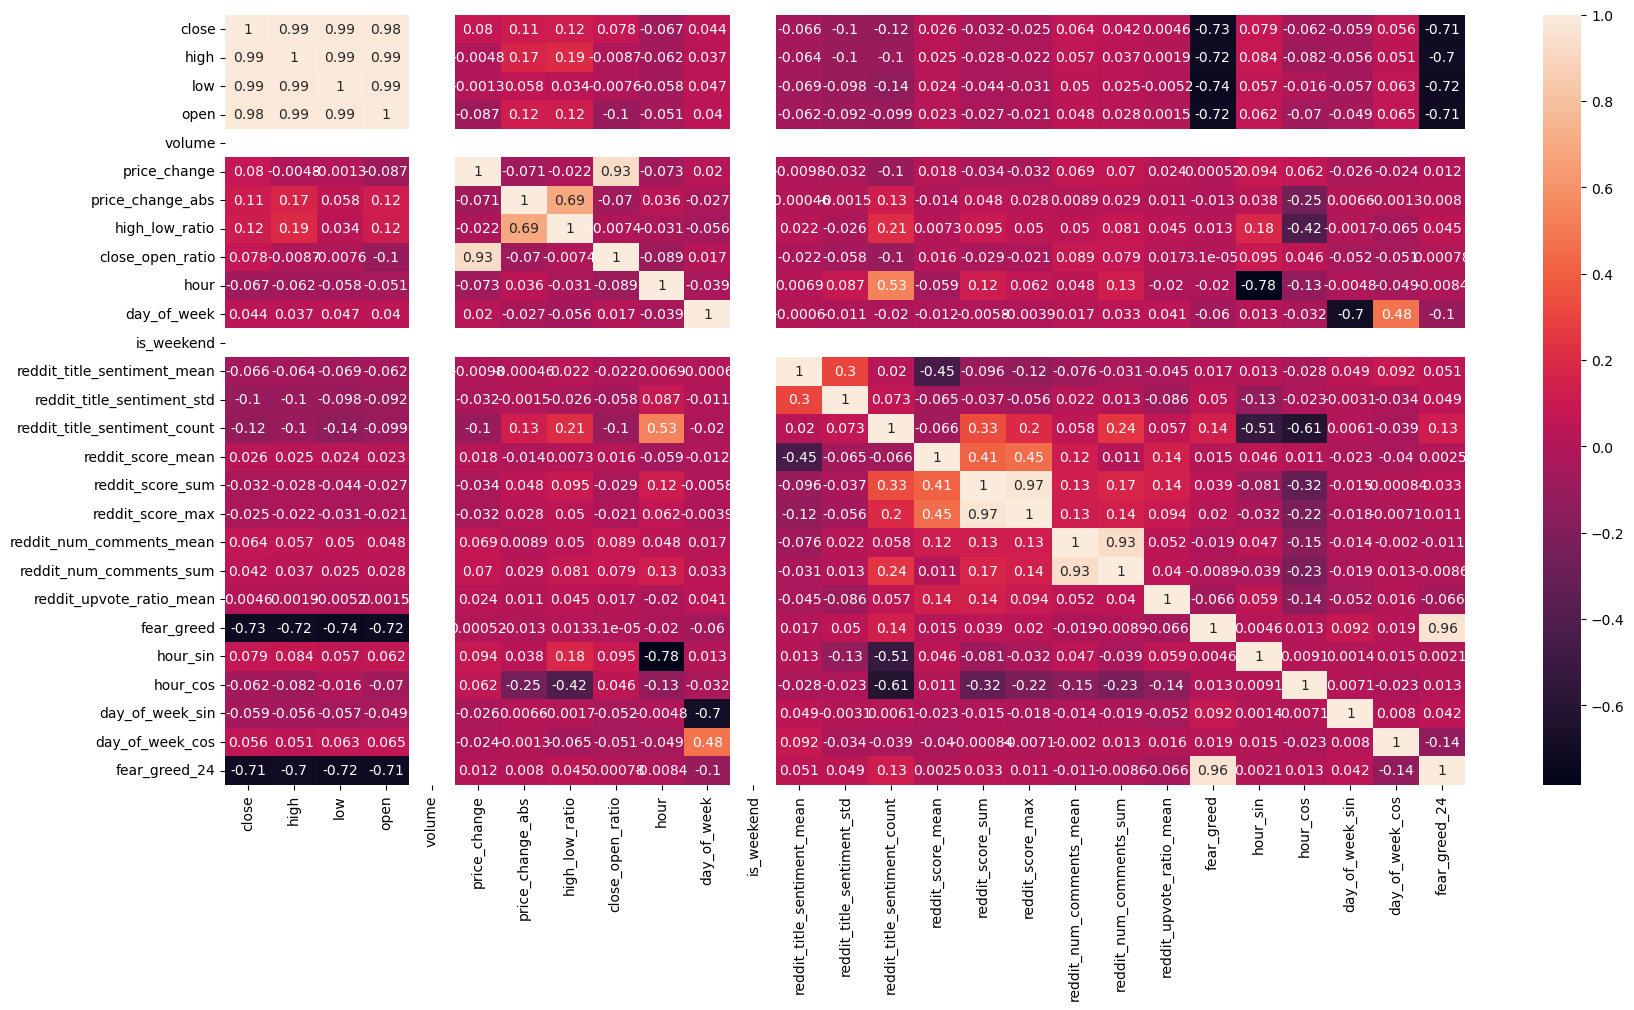

In [136]:
figure, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(df.corr(), annot=True)

In [137]:
df = df[['close', 'fear_greed_24', 'day_of_week', 'hour']]

## Plotting

<Axes: xlabel='Data i czas', ylabel='EUR/PLN'>

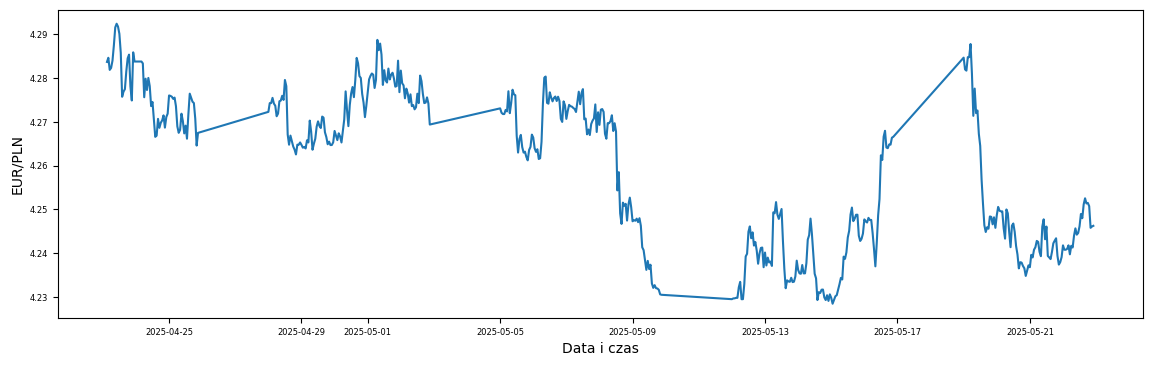

In [138]:
figure, ax = plt.subplots(figsize=(14, 4))

ax.tick_params(labelsize=6)
ax.set_xlabel('Data i czas')
ax.set_ylabel('EUR/PLN')

sns.lineplot(df.close)


<Axes: xlabel='datetime', ylabel='fear_greed_24'>

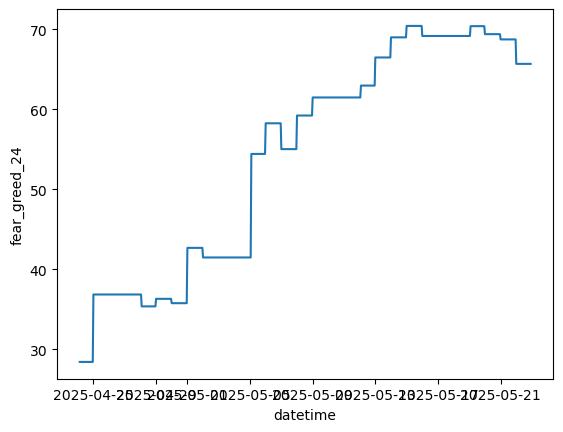

In [139]:
sns.lineplot(df.fear_greed_24)

## Selecting data

In [140]:
df.index

DatetimeIndex(['2025-04-23 03:00:00', '2025-04-23 04:00:00',
               '2025-04-23 05:00:00', '2025-04-23 06:00:00',
               '2025-04-23 07:00:00', '2025-04-23 08:00:00',
               '2025-04-23 09:00:00', '2025-04-23 10:00:00',
               '2025-04-23 11:00:00', '2025-04-23 12:00:00',
               ...
               '2025-05-22 13:00:00', '2025-05-22 14:00:00',
               '2025-05-22 15:00:00', '2025-05-22 16:00:00',
               '2025-05-22 17:00:00', '2025-05-22 18:00:00',
               '2025-05-22 19:00:00', '2025-05-22 20:00:00',
               '2025-05-22 21:00:00', '2025-05-22 22:00:00'],
              dtype='datetime64[ns]', name='datetime', length=516, freq=None)

In [141]:
df['first_day_of_week'] = (df.index - ((df.day_of_week - 1) * pd.Timedelta(1, 'D')))
df.first_day_of_week = df.first_day_of_week.dt.date

In [142]:
print(df.to_string())

                       close  fear_greed_24  day_of_week  hour first_day_of_week
datetime                                                                        
2025-04-23 03:00:00  4.28371            NaN            3     3        2025-04-21
2025-04-23 04:00:00  4.28466            NaN            3     4        2025-04-21
2025-04-23 05:00:00  4.28189            NaN            3     5        2025-04-21
2025-04-23 06:00:00  4.28234            NaN            3     6        2025-04-21
2025-04-23 07:00:00  4.28400            NaN            3     7        2025-04-21
2025-04-23 08:00:00  4.28748            NaN            3     8        2025-04-21
2025-04-23 09:00:00  4.29160            NaN            3     9        2025-04-21
2025-04-23 10:00:00  4.29244            NaN            3    10        2025-04-21
2025-04-23 11:00:00  4.29179            NaN            3    11        2025-04-21
2025-04-23 12:00:00  4.29012            NaN            3    12        2025-04-21
2025-04-23 13:00:00  4.28580

In [143]:
last_first_day_of_week = df.first_day_of_week.max()

In [144]:
last_first_day_of_week

datetime.date(2025, 5, 19)

### Selecting only the last week

In [145]:
first_day_of_week_list = list(df.first_day_of_week.unique())
first_day_of_week_list.sort(reverse=True)

In [146]:
first_day_of_week_list

[datetime.date(2025, 5, 19),
 datetime.date(2025, 5, 12),
 datetime.date(2025, 5, 5),
 datetime.date(2025, 4, 28),
 datetime.date(2025, 4, 21)]

In [147]:
for fdow in first_day_of_week_list:
    if len(df[df.first_day_of_week == fdow]) == 118:
        df = df[df.first_day_of_week == fdow]
        break

In [148]:
len(df)

118

In [149]:
print(df.to_string())

                       close  fear_greed_24  day_of_week  hour first_day_of_week
datetime                                                                        
2025-05-12 00:00:00  4.22950      61.485714            1     0        2025-05-12
2025-05-12 01:00:00  4.22967      61.485714            1     1        2025-05-12
2025-05-12 02:00:00  4.22969      62.971429            1     2        2025-05-12
2025-05-12 03:00:00  4.22980      62.971429            1     3        2025-05-12
2025-05-12 04:00:00  4.22980      62.971429            1     4        2025-05-12
2025-05-12 05:00:00  4.23221      62.971429            1     5        2025-05-12
2025-05-12 06:00:00  4.23345      62.971429            1     6        2025-05-12
2025-05-12 07:00:00  4.22949      62.971429            1     7        2025-05-12
2025-05-12 08:00:00  4.22950      62.971429            1     8        2025-05-12
2025-05-12 09:00:00  4.23299      62.971429            1     9        2025-05-12
2025-05-12 10:00:00  4.23926

/tmp/ipykernel_6271/3914987584.py:7: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(data=df, x=df.index, y='close', hue='day_of_week', palette=sns.color_palette(), label=['p', 'w', 's', 'czw', 'plt'])


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

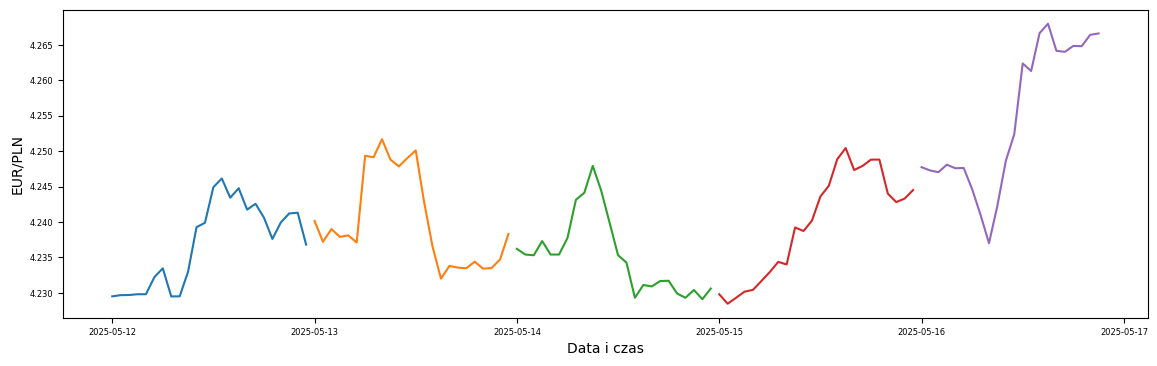

In [ ]:
figure, ax = plt.subplots(figsize=(14, 4))

ax.tick_params(labelsize=6)
ax.set_xlabel('Data i czas')
ax.set_ylabel('EUR/PLN')

sns.lineplot(data=df, x=df.index, y='close', hue='day_of_week', palette=sns.color_palette())

plt.legend(title='Dzień tygodnia')

## Stationarity check

In [151]:
adfuller(df.close)[1]

np.float64(0.41736312905536926)

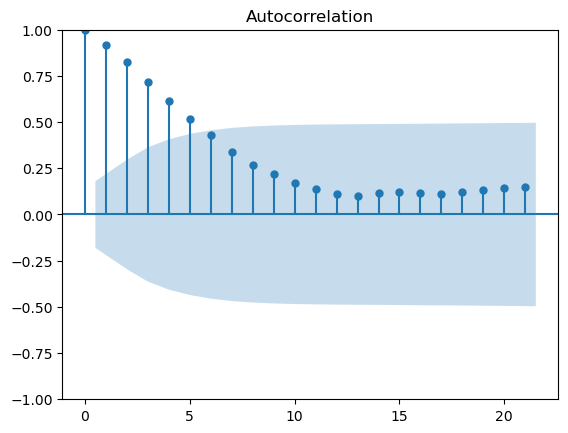

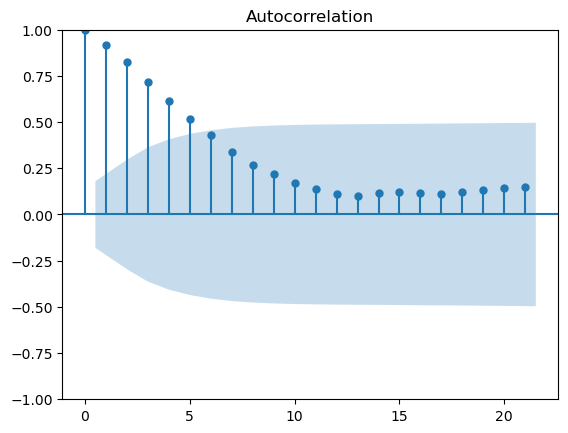

In [152]:
plot_acf(df.close)

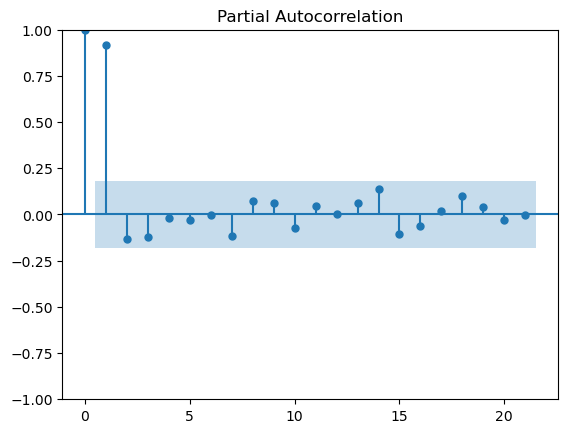

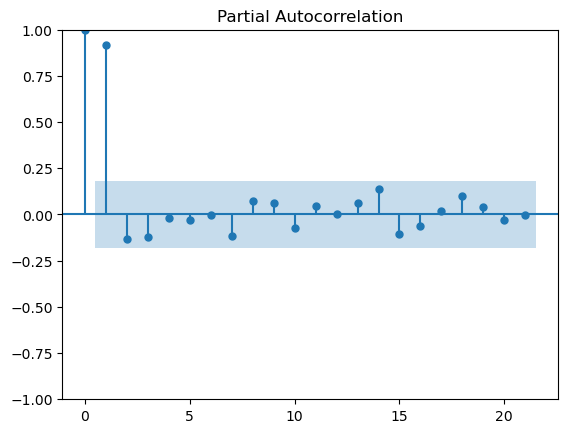

In [153]:
plot_pacf(df.close)

## Splitting the data

In [154]:
train = df[df.day_of_week <= 4]
test = df[df.day_of_week == 5]

In [155]:
train.head()

,close,fear_greed_24,day_of_week,hour,first_day_of_week
datetime,,,,,
2025-05-12 00:00:00,4.22950,61.485714,1,0,2025-05-12
2025-05-12 01:00:00,4.22967,61.485714,1,1,2025-05-12
2025-05-12 02:00:00,4.22969,62.971429,1,2,2025-05-12
2025-05-12 03:00:00,4.22980,62.971429,1,3,2025-05-12
2025-05-12 04:00:00,4.22980,62.971429,1,4,2025-05-12


In [156]:
test.tail()

,close,fear_greed_24,day_of_week,hour,first_day_of_week
datetime,,,,,
2025-05-16 17:00:00,4.26400,69.171429,5,17,2025-05-12
2025-05-16 18:00:00,4.26484,69.171429,5,18,2025-05-12
2025-05-16 19:00:00,4.26480,69.171429,5,19,2025-05-12
2025-05-16 20:00:00,4.26640,69.171429,5,20,2025-05-12
2025-05-16 21:00:00,4.26660,69.171429,5,21,2025-05-12


## Standardization

In [157]:
column_names = ['close', 'fear_greed_24']

train = train[column_names]
train_index = train.index

test = test[column_names]
test_index = test.index


scaler = StandardScaler()
train = scaler.fit_transform(train)
train = pd.DataFrame(train, columns=column_names, index=train_index)

test = scaler.transform(test)
test = pd.DataFrame(test, columns=column_names, index=test_index)

In [158]:
train.describe()

,close,fear_greed_24
count,9.600000e+01,9.600000e+01
mean,4.645821e-14,-3.441691e-15
std,1.005249e+00,1.005249e+00
min,-1.452181e+00,-1.977611e+00
25%,-8.894296e-01,-5.488779e-01
50%,-1.144506e-01,1.914882e-01
75%,8.108725e-01,7.510961e-01
max,2.081622e+00,1.122517e+00


In [159]:
test.describe()

,close,fear_greed_24
count,22.000000,22.000000
mean,2.520010,0.686716
std,1.552339,0.000000
min,-0.152477,0.686716
25%,1.422300,0.686716
50%,1.904337,0.686716
75%,4.053622,0.686716
max,4.560786,0.686716


In [160]:
train

,close,fear_greed_24
datetime,,
2025-05-12 00:00:00,-1.293909,-1.977611
2025-05-12 01:00:00,-1.268002,-1.977611
2025-05-12 02:00:00,-1.264954,-1.462574
2025-05-12 03:00:00,-1.248191,-1.462574
2025-05-12 04:00:00,-1.248191,-1.462574
...,...,...
2025-05-15 19:00:00,1.643308,1.122517
2025-05-15 20:00:00,0.912831,1.122517
2025-05-15 21:00:00,0.730249,1.122517


In [161]:
test

,close,fear_greed_24
datetime,,
2025-05-16 00:00:00,1.480464,0.686716
2025-05-16 01:00:00,1.410507,0.686716
2025-05-16 02:00:00,1.372409,0.686716
2025-05-16 03:00:00,1.533729,0.686716
2025-05-16 04:00:00,1.457677,0.686716
2025-05-16 05:00:00,1.462249,0.686716
2025-05-16 06:00:00,1.010219,0.686716
2025-05-16 07:00:00,0.456302,0.686716
2025-05-16 08:00:00,-0.152477,0.686716


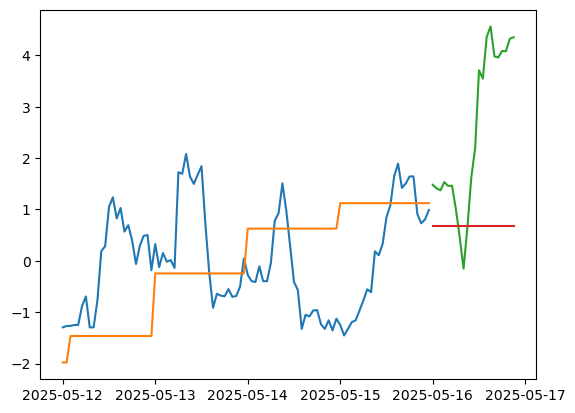

In [162]:
plt.plot(train)
plt.plot(test)

## Training the model

### Without differencing

In [163]:
arima = auto_arima(train.close, train[['fear_greed_24']])

/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was ren

In [164]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(3, 0, 1)   Log Likelihood                 -48.228
Date:                Sun, 25 May 2025   AIC                            108.457
Time:                        23:31:25   BIC                            123.843
Sample:                    05-12-2025   HQIC                           114.676
                         - 05-15-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
fear_greed_24     0.1645      0.180      0.914      0.361      -0.188       0.517
ar.L1             0.3112      0.179      1.738      0.082      -0.040       0.662
ar.L2             0.7796      0.160      4.862      0.000       0.465       1.094
ar.L3            -0.2928      0.109     -2.689      0.007      -0.506      -0.079
ma.L1             0.7741      0.207      3.731      0.000       0.367       1.181
sigma2            0.1564      0.016      9.667      0.000       0.125       0.188
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                40.97
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.81
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
n_periods = 22
forecast, conf_int = arima.predict(n_periods=n_periods, return_conf_int=True, X=test[['fear_greed_24']])

/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='datetime', ylabel='close'>

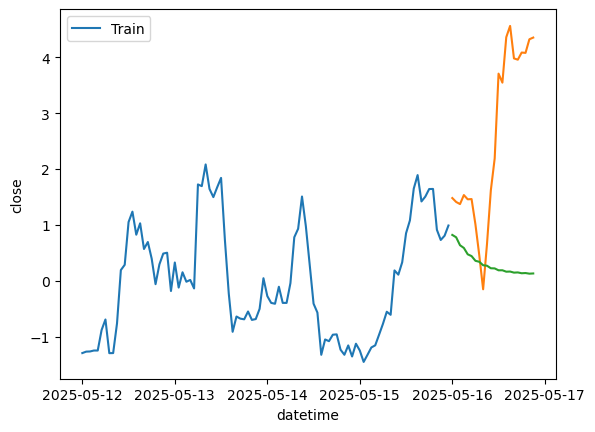

In [166]:
sns.lineplot(train.close, label='Train')
sns.lineplot(test.close)
sns.lineplot(forecast)

In [167]:
mean_absolute_error(test.close, forecast)

2.242921853690309

In [168]:
root_mean_squared_error(test.close, forecast)

2.756776138949814

### With differencing

In [169]:
arima = auto_arima(train.close, train[['fear_greed_24']], d=1)

/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was ren

In [170]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -53.868
Date:                Sun, 25 May 2025   AIC                            111.735
Time:                        23:31:26   BIC                            116.843
Sample:                    05-12-2025   HQIC                           113.799
                         - 05-15-2025                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
fear_greed_24     0.1030      0.306      0.337      0.736      -0.496       0.702
sigma2            0.1820      0.017     10.950      0.000       0.149       0.215
===================================================================================
Ljung-Box (L1) (Q):                   1.21   Jarque-Bera (JB):                38.66
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [171]:
n_periods = 22
forecast, conf_int = arima.predict(n_periods=n_periods, return_conf_int=True, X=test[['fear_greed_24']])

/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/kacpera/anaconda3/envs/ds/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: xlabel='datetime', ylabel='close'>

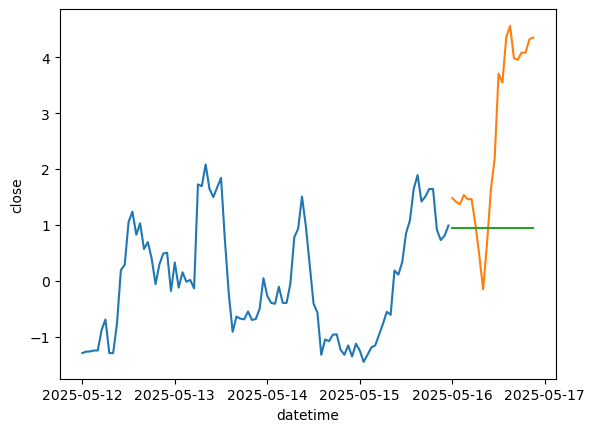

In [172]:
sns.lineplot(train.close)
sns.lineplot(test.close)
sns.lineplot(forecast)

In [173]:
mean_absolute_error(test.close, forecast)

1.7462019719704471

In [174]:
root_mean_squared_error(test.close, forecast)

2.187205148820821